import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix 
import sklearn.metrics as metrics
import matplotlib
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# Read dataset
ds = pd.read_csv('VideoGameSales.csv')
ds.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Bin NA_Sales into Blockbuster or NB based on units sold
BlockBuster = ds.loc[:, "Global_Sales"] > 1.0
ds.loc[BlockBuster, "Global_Sales"] = 1
ds.loc[~BlockBuster, "Global_Sales"] = 0
# Drop nulls
nullRemoved = ds.dropna(axis=0) #6825 observations with no nulls
# Convert to int
nullRemoved = nullRemoved.astype({'User_Score':float})

In [4]:
from tabulate import tabulate
tabulate(nullRemoved.info(), headers='keys', tablefmt='psql')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6825 entries, 0 to 16706
Data columns (total 16 columns):
Name               6825 non-null object
Platform           6825 non-null object
Year_of_Release    6825 non-null float64
Genre              6825 non-null object
Publisher          6825 non-null object
NA_Sales           6825 non-null float64
EU_Sales           6825 non-null float64
JP_Sales           6825 non-null float64
Other_Sales        6825 non-null float64
Global_Sales       6825 non-null float64
Critic_Score       6825 non-null float64
Critic_Count       6825 non-null float64
User_Score         6825 non-null float64
User_Count         6825 non-null float64
Developer          6825 non-null object
Rating             6825 non-null object
dtypes: float64(10), object(6)
memory usage: 906.4+ KB


''

In [5]:
#Group like categories: AO -> M, RP -> T, K-A/E10+ -> E

nullRemoved.loc[nullRemoved.loc[:, "Rating"] == "AO", "Rating"] = "M"
nullRemoved.loc[nullRemoved.loc[:, "Rating"] == "K-A", "Rating"] = "E"
nullRemoved.loc[nullRemoved.loc[:, "Rating"] == "RP", "Rating"] = "T"
nullRemoved.loc[nullRemoved.loc[:, "Rating"] == "E10+", "Rating"] = "E"

In [6]:
#Define target and featuress for model using domain knowledge of likely significant attributes related to sales

target =  nullRemoved[['Global_Sales']].values #y
features = nullRemoved[['Platform','Genre','Critic_Score','Critic_Count','User_Score','User_Count','Rating']] 

In [7]:
#Make pipeline that scales and encodes features

preprocess = make_column_transformer(
    (StandardScaler(), ['Critic_Score', 'Critic_Count','User_Score','User_Count' ]), #features scale
    (OneHotEncoder(), ['Platform', 'Genre', 'Rating']) #OHE categorical features
)

In [8]:
#Scale data for use in Kmeans

kmeans_features = preprocess.fit_transform(features).toarray()

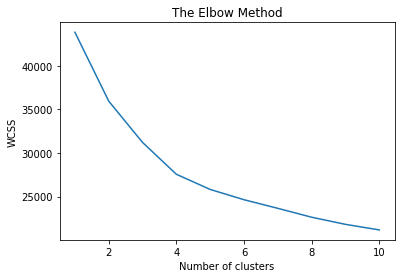

In [9]:
# Use elbow method to determine ideal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(kmeans_features)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()  #4 is ideal number of clusters

In [10]:
#Train/test split

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [11]:
#Fitting K-Means to the dataset

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 69)
y_kmeans = kmeans.fit_predict(kmeans_features)

In [12]:
#Add Kmeans labels to features df

features = features.assign(Kmeans_labels=pd.Series(y_kmeans, index=features.index))

In [13]:
#Train/test split with KMEANS attribute added

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [14]:
#Make Logistic Regression Classification model

model = make_pipeline(
    preprocess,
    LogisticRegression(solver='lbfgs',penalty='l2'))
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)
print("Logistic Regression Score: %f" % model.score(X_test, y_test))

Logistic Regression Score: 0.853544


In [15]:
#Probabiliities for threshold

BothProbabilities = model.predict_proba(features)
probabilities = BothProbabilities[:,1]

In [19]:
#Make Random Forest Classification model

model2 = make_pipeline(
        preprocess,
        RandomForestClassifier(n_estimators=100))
model2.fit(X_train, y_train.ravel())
y_pred2 = model2.predict(X_test)
print("\nRandom Forest Score: %f" % model2.score(X_test, y_test)) 


Random Forest Score: 0.884593


In [20]:
# ProbaProbabiliities for thresholdbiliities for threshold

BothProbabilities2 = model2.predict_proba(features)
probabilities2 = BothProbabilities2[:,1]

In [21]:
#Make Logistic Regression Confusion Matrix and Metrics

cm = confusion_matrix(y_test, y_pred)
print ('\nLogistic Regression Confusion Matrix and Metrics')
Threshold = 0.3 # Some number between 0 and 1
print ("\nProbability Threshold is chosen to be:", Threshold)
predictions = (probabilities > Threshold).astype(int)
tn, fp, fn, tp = cm.ravel()
print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred))
print("\nPrecision:",metrics.precision_score(y_test, y_pred))
print("\nRecall:",metrics.recall_score(y_test, y_pred))
print("\nF1:",metrics.f1_score(y_test, y_pred))
print("\nAverage precision-recall score:",metrics.average_precision_score(y_test, y_pred))


Logistic Regression Confusion Matrix and Metrics

Probability Threshold is chosen to be: 0.3

TP, TN, FP, FN: 127 , 1330 , 62 , 188

Accuracy: 0.8535442296426479

Precision: 0.671957671957672

Recall: 0.4031746031746032

F1: 0.5039682539682541

Average precision-recall score: 0.38105100705039335


In [22]:
# Make Random Forest Confusion Matrix and Metrics
cm2 = confusion_matrix(y_test, y_pred2)
print ('\nRandom Forest Confusion Matrix and Metrics')
Threshold = 0.01 # Some number between 0 and 1
print ("Probability Threshold is chosen to be:", Threshold)
predictions = (probabilities2 > Threshold).astype(int)
tn, fp, fn, tp = cm2.ravel()
print ("TP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)
print("\nAccuracy:",metrics.accuracy_score(y_test, y_pred2))
print("\nPrecision:",metrics.precision_score(y_test, y_pred2))
print("\nRecall:",metrics.recall_score(y_test, y_pred2))
print("\nF1:",metrics.f1_score(y_test, y_pred2))
print("\nAverage precision-recall score:",metrics.average_precision_score(y_test, y_pred2))


Random Forest Confusion Matrix and Metrics
Probability Threshold is chosen to be: 0.01
TP, TN, FP, FN: 168 , 1342 , 50 , 147

Accuracy: 0.8845928529584065

Precision: 0.7706422018348624

Recall: 0.5333333333333333

F1: 0.6303939962476548

Average precision-recall score: 0.49712516728204964


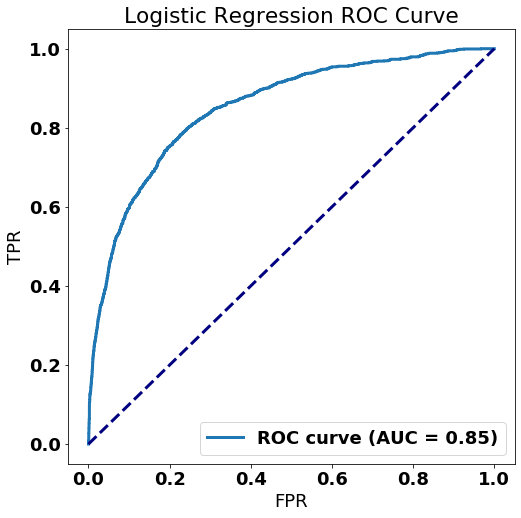

In [23]:
#LR ROC curve

fpr, tpr, th = roc_curve(target, probabilities)
AUC = auc(fpr, tpr)

plt.rcParams["figure.figsize"] = [8, 8] # Square
font = {'weight' : 'bold', 'size' : 18}
matplotlib.rc('font', **font)
plt.figure()
plt.title('Logistic Regression ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show() #ideal threshold is around 0.3

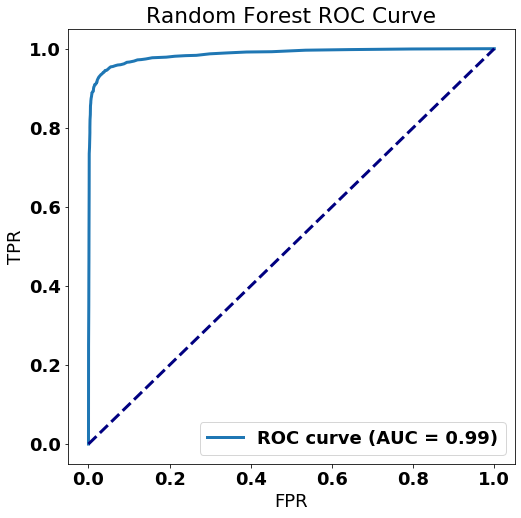

In [21]:
#RF ROC curve

fpr, tpr, th = roc_curve(target, probabilities2)
AUC = auc(fpr, tpr)

plt.rcParams["figure.figsize"] = [8, 8] # Square
font = {'weight' : 'bold', 'size' : 18}
matplotlib.rc('font', **font)
plt.figure()
plt.title('Random Forest ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr, LW=3, label='ROC curve (AUC = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', LW=3, linestyle='--') # reference line for random classifier
plt.legend(loc="lower right")
plt.show() #ideal threshold is around 0.1

In [24]:
#Spot check algorithm performance against other models.

X_train2  = preprocess.fit_transform(X_train).toarray()
models = []
models.append(('LR', LogisticRegression(solver='lbfgs')))
#models.append(('RC', RidgeClassifier()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
# evaluate each model in turn
results = []
names = []
out = []
# need to use preprocess to scale and encode X_train and y_train
for name, model in models:
    #model = preprocess.fit_transform(features).toarray()
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train2, y_train.ravel(), cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.845253 (0.011908)
KNN: 0.840952 (0.009265)
SVM: 0.843696 (0.008824)
RF: 0.865371 (0.008804)


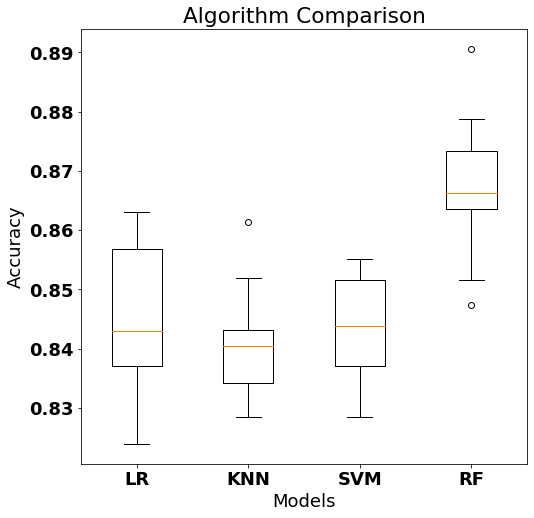

In [47]:
#Compare Algorithms

plt.figure()
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.xlabel('Models')
pyplot.ylabel('Accuracy')
pyplot.show()

In [23]:
#Based upon the ROC curves for each model I tuned the Threshold value to the point on the curve closest to the upper-left corner.
#The Random Forest Classifier is more accurate than the Logistic Regression model when it comes to identifying blockbuster videogames. 
#The ideal number of clusters for Kmeans was 4. Both models are highly accurate, but the recall and F1 rates are much much better for my Random Forest model.
#I conclude that I can can classify games based on whether they will sell one million global units with decent accuracy.
#My model of models shows that I have used two of the highest accuracy classifiers.